In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import numpy as np
np.random.seed(1234)
import scipy.io
# from pyDOE import lhs
import json
import sys
import matplotlib.pyplot as plt

sys.path.append('../../utils')
from basic_model import basic_model
from mtH1D import mt1dtm

In [2]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1

In [17]:
data_FEM = scipy.io.loadmat("../../Data/CM2D0_FEM.mat")
obs_FEM = data_FEM["obs"].flatten()/1e3
# rho_FEM_TE= data_FEM["rho_TE"].flatten()
# phs_FEM_TE= data_FEM["phs_TE"].flatten()
rho_FEM_TM= data_FEM["rho_TM"].flatten()
phs_FEM_TM= data_FEM["phs_TM"].flatten()


H_c = np.loadtxt("../../Data/CM2D0_300s.dat")
obs_c = H_c[:,2]
rho_TM = H_c[:,3]


In [4]:
hp={}
hp["cuda"] = False

hp["Rm1"] = -0.5
hp["Rm2"] = 0.5

hp["net_type"] = "complex"
hp["layers"] = [2, 400,1]
hp["N_y"] = 40#hp["layers"][-2]
hp["N_z"] = 40#hp["layers"][-2]
hp["N_yi"] = 400#hp["N_y"] # number of points on the interface.
hp["N_zi"] = 400#hp["N_z"]

hp["L2"] = 0
# Tanh
hp["activation"] = ["Tanh"]*1
# default,uniform, norml, xavier_normal, xavier_uniform,
hp["init"] = "uniform"

cond = None # 1e-7

In [5]:
freq = 1.0/300
ny = 100
nz = 100

y1 = np.linspace(-2e5,-1e4,ny+1)[:-1]
y2 = np.linspace(-1e4,1e4,ny+1)[:-1]
y3 = np.linspace(1e4,2e5,ny)
# z1 = np.linspace(-2e5,0,nz+1)[:-1]
z2 = np.linspace(0, 5e4,nz+1)[:-1]
z3 = np.linspace(5e4,2e5,nz)
y  = np.concatenate((y1,y2,y3))
z  = np.concatenate((z2,z3))
Y,Z= np.meshgrid(y,z)

In [6]:
BCy = [0,ny,2*ny,3*ny]
BCz = [0,nz,2*nz]
sigma = np.array([[1e-1,1,5e-1],[1e1,1e1,1e1]])
Sigma = np.ones_like(Y)
for ii in range(len(BCy)-1):
    for jj in range(len(BCz)-1):
        Sigma[BCz[jj]:BCz[jj+1],BCy[ii]:BCy[ii+1]]=sigma[jj,ii]
mu_0 = 4*np.pi*1e-7    
omega = 2*np.pi*freq
Beta = np.sqrt(mu_0*Sigma*omega)
II = complex(0,1)

BCy = np.array([0,ny,2*ny,3*ny-1])
BCz = np.array([0,nz,2*nz-1])
sigL = sigma[:,0]
hL   = np.array([z[BCz[i+1]]-z[BCz[i]] for i in range(2)])
sigR = sigma[:,-1]
hR   = hL

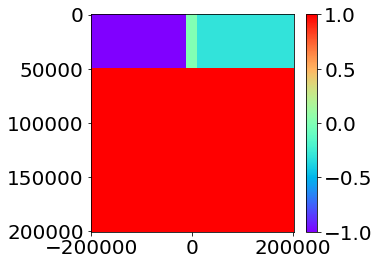

In [7]:
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,2,1)
h = ax.pcolormesh(Y,Z, np.log10(Sigma), 
                  cmap='rainbow',shading='auto')
ax.invert_yaxis()

fig.colorbar(h)
plt.show()

In [8]:
U_real = np.ones_like(Y)
U_real[-1,:] = 0.0
U_imag = np.zeros_like(Y)
u = (U_real,U_imag)



In [9]:
def BC_struct(Z,Y,U_r,U_i,nz,ny,BCz,BCy):
    net_z = len(BCz)-1
    net_y = len(BCy)-1
    Z_t = np.ones((net_y*ny,2))
    u_t = np.ones((net_y*ny,2))
    Z_b = np.ones((net_y*ny,2))
    u_b = np.ones((net_y*ny,2))
    Z_l = np.ones((net_z*nz,2))
    u_l = np.ones((net_z*nz,2))
    Z_r = np.ones((net_z*nz,2))
    u_r = np.ones((net_z*nz,2))
    for jj in range(net_z):   # left and right    
        z0 = np.linspace(Z[BCz[jj],0],Z[BCz[jj+1]-1,0],nz)
        y0 = np.linspace(Y[BCz[jj],0],Y[BCz[jj+1]-1,0],nz)
        Z_l[jj*nz:(jj+1)*nz,:] = np.hstack((y0.flatten()[:,None],z0.flatten()[:,None]))
#         u0 = mt1dte(freq,hL,sigL,z0)
#         u_l[jj*nz:(jj+1)*nz,:] = np.hstack((u0.real.flatten()[:,None],u0.imag.flatten()[:,None]))
        z0 = np.linspace(Z[BCz[jj],-1],Z[BCz[jj+1]-1,-1],nz)
        y0 = np.linspace(Y[BCz[jj],-1],Y[BCz[jj+1]-1,-1],nz)
        Z_r[jj*nz:(jj+1)*nz,:] = np.hstack((y0.flatten()[:,None],z0.flatten()[:,None]))
#     u0 = getE1D(freq,hL,sigL,Z_l[:,1])
    u0 = mt1dtm(freq,hL,sigL,Z_l[:,1])
    u_l= u0.flatten()[:,None]
#     u0 = getE1D(freq,hR,sigR,Z_r[:,1])
    u0 = mt1dtm(freq,hR,sigR,Z_r[:,1])
    u_r= u0.flatten()[:,None]
    for jj in range(net_y): # top and bottom
        z0 = np.linspace(Z[0,BCy[jj]],Z[0,BCy[jj+1]-1],ny)
        y0 = np.linspace(Y[0,BCy[jj]],Y[0,BCy[jj+1]-1],ny)
        Z_t[jj*ny:(jj+1)*ny,:] = np.hstack((y0.flatten()[:,None],z0.flatten()[:,None]))
#         u_r0 = np.linspace(U_r[0,BCy[jj]],U_r[0,BCy[jj]+1],ny)
#         u_i0 = np.linspace(U_i[0,BCy[jj]],U_i[0,BCy[jj]+1],ny)
#         u1 = u0[0]*np.ones_like(z0)
#         u_t[jj*ny:(jj+1)*ny,:] = np.hstack((u1.real.flatten()[:,None],u1.imag.flatten()[:,None]))
        z0 = np.linspace(Z[-1,BCy[jj]],Z[-1,BCy[jj+1]-1],ny)
        y0 = np.linspace(Y[-1,BCy[jj]],Y[-1,BCy[jj+1]-1],ny)
        Z_b[jj*ny:(jj+1)*ny,:] = np.hstack((y0.flatten()[:,None],z0.flatten()[:,None]))
#         u_r0 = np.linspace(U_r[-1,BCy[jj]],U_r[-1,BCy[jj+1]],ny)
#         u_i0 = np.linspace(U_i[-1,BCy[jj]],U_i[-1,BCy[jj+1]],ny)
#         u1 = u0[-1]*np.ones_like(z0)
#         u_b[jj*ny:(jj+1)*ny,:] = np.hstack((u1.real.flatten()[:,None],u1.imag.flatten()[:,None]))
    u1 = u0[0]*np.ones_like(Z_t[:,1])
    u_t = u1.flatten()[:,None]
    u1 = u0[-1]*np.ones_like(Z_b[:,1])
    u_b = u1.flatten()[:,None]
    Z_dict = {
        "Z_t": Z_t,
        "Z_b": Z_b,
        "Z_l": Z_l,
        "Z_r": Z_r,
        "u_t": u_t,
        "u_b": u_b,
        "u_r": u_r,
        "u_l": u_l

    }
    return Z_dict

In [10]:
# BCy = np.array([0,int(0.9*ny),ny,int(1.2*ny),2*ny,int(2.1*ny),3*ny])
BCy = np.array([0,int(0.8*ny),ny,2*ny,3*ny])
BCz = np.array([0,nz,2*nz])
Z_u = BC_struct(Z,Y,U_real,U_imag,hp["N_zi"],hp["N_yi"],BCz,BCy)
u = (U_real,U_imag)
BCy[-1] = 3*ny-1
BCz[-1] = 2*nz-1
pinn = basic_model(hp, Z_u,Y,Z,Beta,u, BCy,BCz)
# pinn.summary()
# 'gelsd', 'gelsy', 'gelss'
pinn.train(cond,'gelsd',"uniform","none")
# A = pinn.get_A()

all time: 00:14


In [11]:
u_pred = pinn.predict_cpu(Y,Z,BCy,BCz)

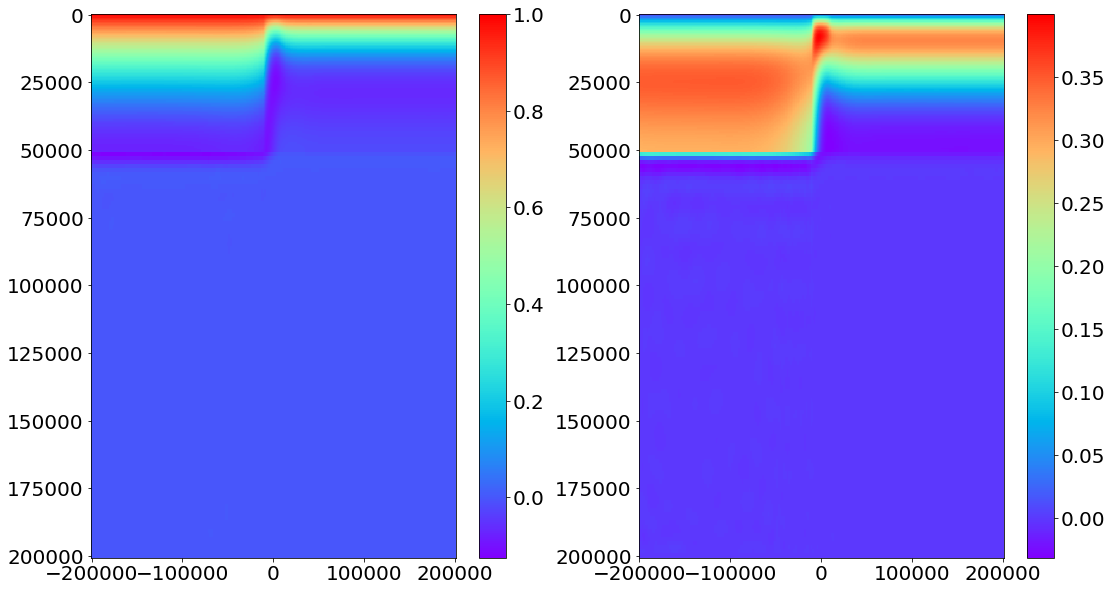

In [12]:
fig = plt.figure(figsize=(18,10))
ax = plt.subplot(1,2,1)
h = ax.pcolormesh(Y,Z, u_pred.real, cmap='rainbow',shading='auto')
ax.invert_yaxis()
fig.colorbar(h)

ax = plt.subplot(1,2,2)
h = ax.pcolormesh(Y,Z, u_pred.imag, cmap='rainbow',shading='auto')
ax.invert_yaxis()
fig.colorbar(h)
# plt.savefig("./imag/full_uniform_sample.png")
plt.show()

In [13]:
y[BCy]

array([-200000.,  -48000.,  -10000.,   10000.,  200000.])

In [19]:
Y_obs = np.linspace(-4e4,4e4,321)
id_b = 1 # idx of model where obssevation begin(from 1) 
id_e = 1# idx of model where obssevation end 

idx0 = np.where(Y_obs>y[BCy[id_b]])[0][0]
Y_0 = Y_obs[0:idx0]
Z_air = np.zeros(len(Y_0)) # 空气-地面分界面
u_pred, u_x = pinn.predict_H(Y_0,Z_air, 0,id_b-1)
u_x = u_x/Sigma[0,BCy[id_b-1]]
for ii in range(id_b+1,len(BCy)-id_e):
    idx = np.where(Y_obs>y[BCy[ii]])[0][0]
    Y_0 = Y_obs[idx0:idx]
    Z_air = np.zeros(len(Y_0))
    u_pred0, u_x0 = pinn.predict_H(Y_0,Z_air, 0,ii-1)
    u_x0 = u_x0/Sigma[0,BCy[ii-1]]

    u_pred = np.concatenate((u_pred,u_pred0),0)
    u_x    = np.concatenate((u_x,u_x0),0)
    idx0 = np.copy(idx)


ii = len(BCy)-id_e
Y_0 = Y_obs[idx:]
Z_air = np.zeros(len(Y_0)) # 空气-地面分界面
u_pred0, u_x0 = pinn.predict_H(Y_0,Z_air, 0,ii-1)
u_x0 = u_x0/Sigma[0,BCy[ii-1]]
    
u_pred = np.concatenate((u_pred,u_pred0),0)
u_x    = np.concatenate((u_x,u_x0),0)

Hx   = u_pred
Ey = u_x

Zyx = Ey/Hx
rho_a = np.abs(Zyx)**2/(omega*mu_0)

phs_a = (np.arctan2(Zyx.imag,Zyx.real)* 180.0 / np.pi-180)*(-1.00)


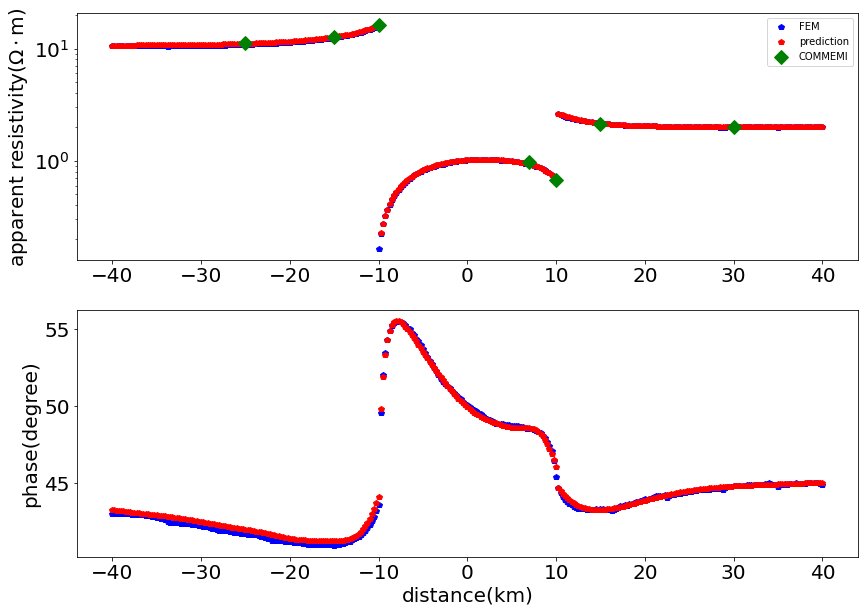

In [21]:
fig = plt.figure(figsize=(14,10))
ax = plt.subplot(2,1,1)
ax.plot(obs_FEM, rho_FEM_TM,'bp',label="FEM")
ax.plot(Y_obs/1e3, rho_a,'rp',label="prediction")
ax.plot(obs_c, rho_TM,'gD', markersize=10,label="COMMEMI")
ax.set_yscale("log")
ax.set_ylabel(r'apparent resistivity($\Omega\cdot$m)')
ax.legend()

ax = plt.subplot(2,1,2)
ax.plot(Y_obs/1e3, phs_FEM_TM,'bp',label="FEM")
ax.plot(Y_obs/1e3, phs_a,'rp',label="prediction")
ax.set_ylabel('phase(degree)')
ax.set_xlabel('distance(km)')

# plt.savefig("./imag/tanh.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()